In [268]:
!pip install LightGBM

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.pipeline import make_pipeline

# シードの固定
random_seed = 42

# データ前処理

In [2]:
# 訓練/テストデータの読込
train = pd.read_csv('../data/train.csv')
test  = pd.read_csv("../data/test.csv")

In [3]:
display(train.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 特徴エンジニアリング

In [4]:
data = pd.concat([train, test], sort=False)

data["Sex"].replace(["male", "female"], [0, 1], inplace=True)
data["Embarked"].fillna(("S"), inplace=True)
data["Embarked"] = data["Embarked"].map({"S":0, "C":1, "Q":2}).astype(int)
data["Fare"].fillna(np.mean(data["Fare"]), inplace=True)
data["FamilySize"] = data["Parch"] + data["SibSp"] + 1
data["IsAlone"] = 0
data.loc[data["FamilySize"] == 1, "IsAlone"] == 1

2      False
4      False
5      False
6      False
11     False
       ...  
412    False
413    False
414    False
415    False
416    False
Name: IsAlone, Length: 790, dtype: bool

### 特徴エンジニアリング（original）

In [5]:
"""欠損値のない変数を用いてAgeを予測"""
from sklearn.ensemble import RandomForestRegressor

age_features = ["Age", "Pclass", "Sex", "Parch", "SibSp"]

age_df = data[age_features]

# 学習データとテストデータに分割
known_age = age_df[age_df["Age"].notnull()]
unknown_age = age_df[age_df["Age"].isnull()]

X = known_age.iloc[:,1:]
y = known_age.iloc[:, 0]

rfr = RandomForestRegressor(random_state=random_seed, n_estimators=100,)

# 学習
rfr.fit(X, y)

# Age 以外の変数から欠損箇所を予測
pred_age = rfr.predict(unknown_age.iloc[:,1:])

data.loc[age_df["Age"].isnull(), "Age"] = pred_age

<Axes: xlabel='Title', ylabel='Survived'>

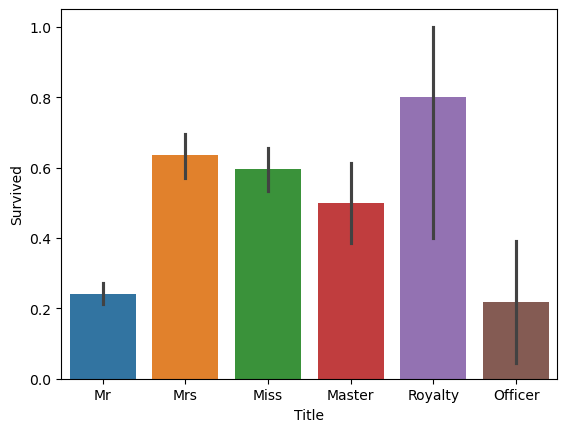

In [6]:
"""Nameから継承を取得"""
data['Title'] = data['Name'].map(lambda x: x.split(', ')[1].split('. ')[0])
data['Title'].replace(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer', inplace=True)
data['Title'].replace(['Don', 'Sir',  'the Countess', 'Lady', 'Dona'], 'Royalty', inplace=True)
data['Title'].replace(['Mme', 'Ms'], 'Mrs', inplace=True)
data['Title'].replace(['Mlle'], 'Miss', inplace=True)
data['Title'].replace(['Jonkheer'], 'Master', inplace=True)
sns.barplot(x='Title', y='Survived', data=data, hue="Title")


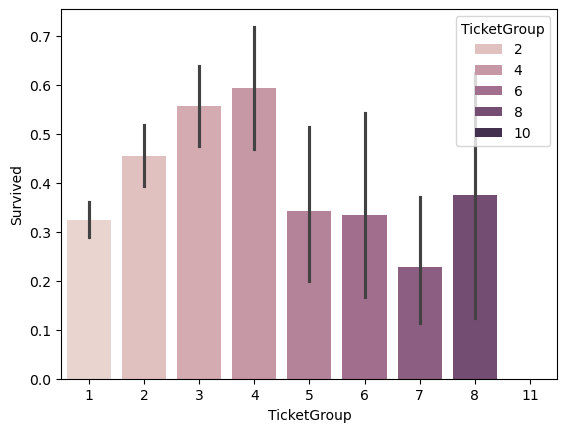

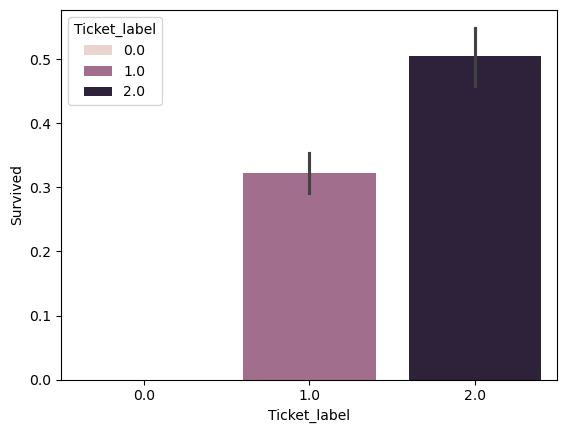

In [7]:
"""Ticketから同じ部屋のメンバは同じ運命を共にしやすい,人数によって生存のしやすさが変わる説"""

# ----------- Ticket ----------------
# 同一Ticketナンバーの人が何人いるかを特徴量として抽出
Ticket_Count = dict(data['Ticket'].value_counts())
data['TicketGroup'] = data['Ticket'].map(Ticket_Count)
sns.barplot(x='TicketGroup', y='Survived', data=data, hue="TicketGroup")
plt.show()

# 生存率で3つにグルーピング
data.loc[(data['TicketGroup']>=2) & (data['TicketGroup']<=4), 'Ticket_label'] = 2
data.loc[(data['TicketGroup']>=5) & (data['TicketGroup']<=8) | (data['TicketGroup']==1), 'Ticket_label'] = 1
data.loc[(data['TicketGroup']>=11), 'Ticket_label'] = 0
sns.barplot(x='Ticket_label', y='Survived', data=data, hue="Ticket_label")
plt.show()


### データ分割

In [8]:
# 使用する特徴量
features = [
    "PassengerId",
    "Survived", # 目的変数
    "Pclass",
    "Title",
    "Ticket_label",
    "Sex",
    "Age",
    "SibSp",
    "Parch",
    "Embarked",
    "Fare",
    "FamilySize",
    "IsAlone"
]

# 特徴エンジニアリングで生成したカテゴリカル変数の One-Hot エンコーディング
print("Encoding前")
display(data[features].head())
data = pd.get_dummies(data[features])
display(data)

train = data[:len(train)]
test  = data[len(train):]


# 訓練データとテストデータに分割
y = train.pop("Survived")
test.pop("Survived")
X = train
X_test = test

Encoding前


,PassengerId,Survived,Pclass,Title,Ticket_label,Sex,Age,SibSp,Parch,Embarked,Fare,FamilySize,IsAlone
0,1,0.0,3,Mr,1.0,0,22.0,1,0,0,7.2500,2,0
1,2,1.0,1,Mrs,2.0,1,38.0,1,0,1,71.2833,2,0
2,3,1.0,3,Miss,1.0,1,26.0,0,0,0,7.9250,1,0
3,4,1.0,1,Mrs,2.0,1,35.0,1,0,0,53.1000,2,0
4,5,0.0,3,Mr,1.0,0,35.0,0,0,0,8.0500,1,0


,PassengerId,Survived,Pclass,Ticket_label,Sex,Age,SibSp,Parch,Embarked,Fare,FamilySize,IsAlone,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
0,1,0.0,3,1.0,0,22.000000,1,0,0,7.2500,2,0,0,0,1,0,0,0
1,2,1.0,1,2.0,1,38.000000,1,0,1,71.2833,2,0,0,0,0,1,0,0
2,3,1.0,3,1.0,1,26.000000,0,0,0,7.9250,1,0,0,1,0,0,0,0
3,4,1.0,1,2.0,1,35.000000,1,0,0,53.1000,2,0,0,0,0,1,0,0
4,5,0.0,3,1.0,0,35.000000,0,0,0,8.0500,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,1.0,0,28.328063,0,0,0,8.0500,1,0,0,0,1,0,0,0
414,1306,NaN,1,2.0,1,39.000000,0,0,1,108.9000,1,0,0,0,0,0,0,1
415,1307,NaN,3,1.0,0,38.500000,0,0,0,7.2500,1,0,0,0,1,0,0,0
416,1308,NaN,3,1.0,0,28.328063,0,0,0,8.0500,1,0,0,0,1,0,0,0


In [9]:
# 訓練データを訓練データと検証データに分割
# ホールドアウト法
X_train, X_valid, y_train, y_valid = train_test_split(
    X.iloc[:,1:], # PassengerId 排除
    y,
    test_size=0.3,
    random_state=random_seed,
    stratify=y
)

# モデルの構築・学習
- ランダムフォレスト

## 関数

In [10]:
from sklearn.model_selection import cross_val_score
import statistics

def print_acc(
    y_true: list,
    y_pred: list,
    model,
):
    acc = accuracy_score(y_true=y_true, y_pred=y_pred)
    print("ホールドアウト法")
    print(f"精度: {acc}")
    print("\n交差検証（分割数:10）")
    scores = cross_val_score(model, X, y, cv=10)
    print(f"精度: {scores.mean()}")
    print(f"交差検証（最大）: {max(scores)}")
    print(f"標準偏差: {statistics.stdev(scores)}")

In [11]:
"""ランダムフォレスト"""
from sklearn.ensemble import RandomForestClassifier

# インスタンス作成
model = RandomForestClassifier(
    n_estimators=50,
    warm_start=True,
    max_features="sqrt",
    max_depth=9,
    random_state=random_seed
)


# モデルの学習
model.fit(X_train, y_train)

# 予測
y_pred = model.predict(X_valid)
y_pred = (y_pred > 0).astype(int)

print_acc(y_true=y_valid, y_pred=y_pred, model=model)


# 精度: 0.7873134328358209

ホールドアウト法
精度: 0.7985074626865671

交差検証（分割数:10）
精度: 0.8305368289637952
交差検証（最大）: 0.8876404494382022
標準偏差: 0.0492061921249684


In [29]:
"""LightGBM
LightGBMはカテゴリカル変数の前処理が不要だからもう一度読み込む
"""
import lightgbm as lgb

# カテゴリカル変数
categorical_cols = ["Embarked", "Pclass", "Sex"]

# モデルのインスタンス作成
model = lgb.LGBMClassifier(
    objective="binary",
    learning_rate=1.0,
    num_leaves=20,
    max_depth=5,
    verbosity=-1
)

# 学習
model.fit(X_train, y_train)

y_pred = model.predict(X_valid)

print_acc(y_true=y_valid, y_pred=y_pred, model=model)

ホールドアウト法
精度: 0.8022388059701493

交差検証（分割数:10）
精度: 0.7553932584269664
交差検証（最大）: 0.8764044943820225
標準偏差: 0.09360006912992619


In [54]:
"""
LightGBMを用いてハイパーパラメータチューニング
"""

# モデルのインスタンス作成
model = lgb.LGBMClassifier()

# チューニングしたいハイパーパラメータ
params = {
    "objective": ["binary"],
    "n_estimators": [175],
    "leaning_rate": [1.5],
    "num_leaves": [10],
    "max_depth": [5],
    "random_seed": [42],
    "verbosity": [-1]
}

# グリッドサーチのインスタンス作成
gs_cv = GridSearchCV(model, params, cv=5)

# グリッドサーチ
gs_cv.fit(X_train, y_train)


best = gs_cv.best_estimator_
print(gs_cv.best_params_)

y_pred = best.predict(X_valid)

print_acc(y_true=y_valid, y_pred=y_pred, model=best)

{'leaning_rate': 1.5, 'max_depth': 5, 'n_estimators': 175, 'num_leaves': 10, 'objective': 'binary', 'random_seed': 42, 'verbosity': -1}
ホールドアウト法
精度: 0.8059701492537313

交差検証（分割数:10）
精度: 0.7889762796504369
交差検証（最大）: 0.8539325842696629
標準偏差: 0.08865510398740895


# Submission

In [55]:
predictions = best.predict(X_test.iloc[:, 1:]).astype(int) # PassengerId 排除

output = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': predictions})
output.to_csv('../data/submission.csv', index=False)
print("Your submission was successfully saved!")
print(model.__class__)

Your submission was successfully saved!
<class 'lightgbm.sklearn.LGBMClassifier'>
